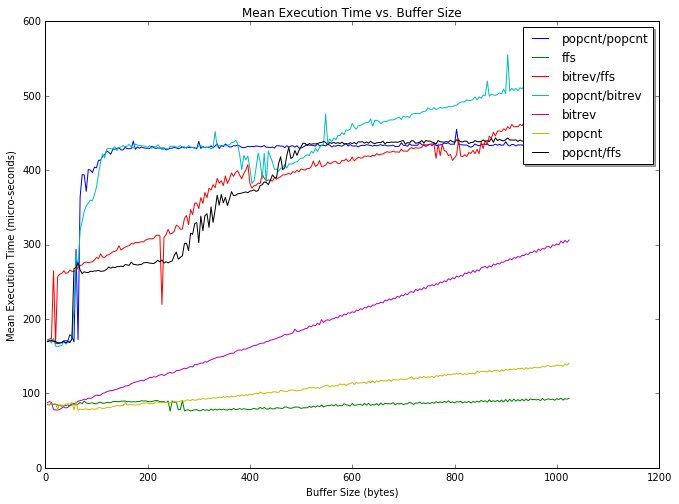

In [6]:
import sys

# add a directory to the module search paths for pycbm
sys.path.append("../module")

import itertools
import threading
import pycbm
import array
import random
import numpy as np
import time
from matplotlib import pyplot as plt
%matplotlib inline

N = 256          # max buffer size
M = 4294967295   # single value range (U32)
R = 50           # averaging rounds

class Benchmark:
	def __init__(self, name, func, it):
		self.it   = it
		self.name = name
		self.func = func
		self.time = 0
		
		self.buff_in  = array.array('I', range(N))
		self.buff_out = array.array('I', range(N))
		
		# populate buffers with randome values
		for i in range(N):
			self.buff_in[i]  = random.randint(0,M)
			self.buff_out[i] = random.randint(0,M)
			
class TimerMonitor:
	def __init__(self):
		self.total_time = 0
		self.lock = threading.Lock()
	def AddTime(self,time):
		self.lock.acquire()
		self.total_time += time
		self.lock.release()

def JobsName(str1,str2):
	if str1 == "none":
		return str2
	elif str2 == "none":
		return str1
	else:
		return str1+"/"+str2
		
def thread_executor(benchmark,size,timer):
	t0 = time.time()
	for i in range(j.it):
		benchmark.func(benchmark.buff_in[0:size], benchmark.buff_out[0:size])
	t1 = time.time()
	timer.AddTime(t1-t0)

lib = pycbm.pycbm();

none_bm   = Benchmark("none"  , None,          R)
popcnt_bm = Benchmark("popcnt", lib.popcnt32n, R)
bitrev_bm = Benchmark("bitrev", lib.bitrev32n, R)
ffs_bm    = Benchmark("ffs"   , lib.ffs32n,    R)

thread_jobs = [ ops for ops in itertools.combinations([none_bm,popcnt_bm,bitrev_bm,ffs_bm], 2) ]
thread_jobs.append((popcnt_bm,popcnt_bm))

y_data = dict()
for jobs in thread_jobs:
	y_data[JobsName(jobs[0].name,jobs[1].name)] = []

x_data = []

for i in range(N):
	x_data.append(4*(i+1)) # i words = 4i bytes
	for jobs in thread_jobs:
		timer = TimerMonitor()
		
		threads = []
		for j in jobs:
			if j.func != None:
				t = threading.Thread(target=thread_executor, args=(j, i+1, timer))
				threads.append(t)
				t.start()
		for t in threads:
			t.join()
		
		# save in units of micro-seconds
		avg_exe_time = 1e6*(timer.total_time)/R
		
		y_data[JobsName(jobs[0].name,jobs[1].name)].append(avg_exe_time)

fig, tgraph = plt.subplots()
fig.set_size_inches(11, 8)
tgraph.set_title("Mean Execution Time vs. Buffer Size")
tgraph.set_xlabel("Buffer Size (bytes)")
tgraph.set_ylabel("Mean Execution Time (micro-seconds)")

for key in y_data.keys():
	tgraph.plot(np.array(x_data),np.array(y_data[key]), label=key)
	
legend = tgraph.legend(loc='upper right', shadow=True)
plt.show()
